In [12]:
%matplotlib widget

In [13]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

### Load lattice

In [14]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/matching_constraints.py')

In [15]:
### Select the cell
line = env['cell_u']

In [16]:
# Load cell quad strengths from previous match
env.vars.load_json('strengths_quads_00_arc_cell.json')

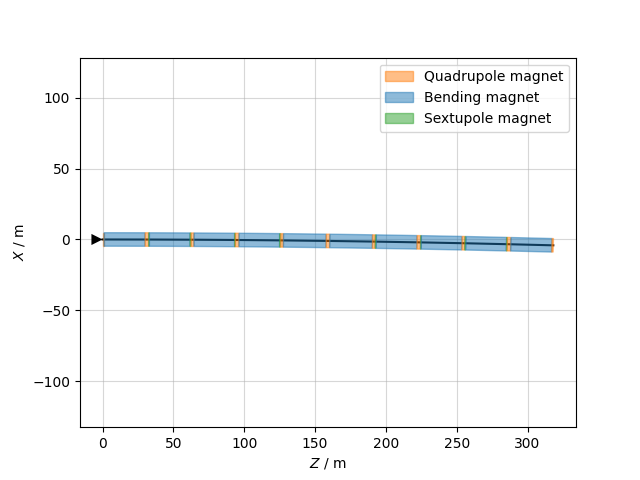

In [17]:
line.survey().plot()

### Define four sextupole families

In [18]:
env.vars.default_to_zero = True
env['ksf1'] = 'ksffam1'
env['ksf2'] = 'ksffam2'
env['ksd1'] = 'ksdfam1'
env['ksd2'] = 'ksdfam2'
env.vars.default_to_zero = False

### Match linear chromaticity

In [19]:
opt_chrom = line.match(
    name='linear chromaticity',
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2'], step=1e-4),
    targets=xt.TargetSet(dqx=env['dqx_cell'], dqy=env['dqy_cell'], tol=1e-3)
)
opt = opt_chrom
opt.step(20)

                                             
Optimize [linear chromaticity] - start penalty: 1.187                         
Matching: model call n. 7 penalty = 2.7961e-04              
Optimize [linear chromaticity] - end penalty:  0.000279607                            


In [20]:
opt.target_status()

Target status:               alty = 2.7961e-04              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    dqx    True  -0.000279607      0.131888      0.132168 line=cell_u, 'dqx', val=0.132168, tol=0. ...
1  ON    dqy    True   3.77395e-08      0.135034      0.135034 line=cell_u, 'dqy', val=0.135034, tol=0. ...


## Starfish characterization

In [21]:
# Build an auxiliary line with a large number of cells
aux_line = 300*env['cell_u']

In [22]:
# Tunes
tw = aux_line.twiss4d()
print(f'qx={tw.qx:.4f} qy={tw.qy:.4f}')

qx=211.8753 qy=185.2230


In [23]:
# Bring fractional tunes on 0.2/0.2
opt_tunes = aux_line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6'], step=1e-5),
    targets=xt.TargetSet(qx=212.2, qy=185.2, tol=1e-5)
)
opt_tunes.step(40)

                                             
Optimize - start penalty: 3.256                             
Matching: model call n. 17 penalty = 1.9147e-07              
Optimize - end penalty:  1.91473e-07                            


In [24]:
# Look at quadrupole strength change
opt_tunes.target_status()
opt_tunes.vary_status()

Target status:               nalty = 1.9147e-07              
id state tag tol_met       residue   current_val    target_val description                          
0  ON    qx     True   1.45984e-08         212.2         212.2 'qx', val=212.2, tol=1e-05, weight=10
1  ON    qy     True  -1.23897e-08         185.2         185.2 'qy', val=185.2, tol=1e-05, weight=10
Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqd1 None           -0.0133482 None           -0.0133447         1e-05             1
1  ON        OK  kqf2 None            0.0111405 None            0.0111273         1e-05             1
2  ON        OK  kqd3 None           -0.0135764 None           -0.0135698         1e-05             1
3  ON        OK  kqf4 None            0.0112145 None             0.011201         1e-05             1
4  ON        OK  kqd5 None           -0.0138718 None           -0.0138652         1e-05        

### Plot "starfish"

In [25]:
import sys
sys.path.append('../002_design_optics/')
from starfish import Starfish

The FCC toolkit includes a `starfish` action that tracks five turns and measures the rms of the normalize momenta at the fifth turn, which is expected to be zero in the absence of amplitude detuning.

In [26]:
nemitt_x=1e-7
nemitt_y=1e-8
n_test = 10

from starfish import Starfish
starfish = Starfish(aux_line, nemitt_x=nemitt_x, nemitt_y=nemitt_y, n_test=n_test)

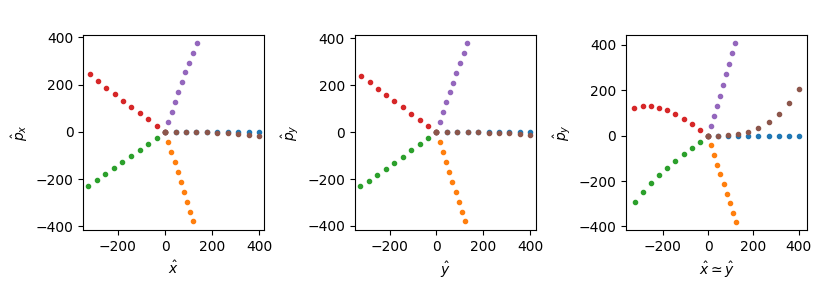

In [27]:
sf = starfish.run(plot=True)

In [28]:
# Measured detuning
sf['px_norm_rms_5'], sf['py_norm_rms_5'], sf['pxy_norm_rms_5']

(np.float64(5.887234808755427),
 np.float64(3.5900501010425567),
 np.float64(66.91114488459597))

In [29]:
# Optimize detuning while keeping linear chromaticity
opt_starfish = line.match(
    name='starfish',
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2'], step=1e-4),
    targets=[xt.TargetSet(dqx=env['dqx_cell'], dqy=env['dqy_cell'], tol=1e-3),
             starfish.target('px_norm_rms_5', 0, tol=0.1),
             starfish.target('pxy_norm_rms_5', 0, tol=0.1)]
)
opt = opt_starfish
opt.step(10)

                                             
Optimize [starfish] - start penalty: 67.17                         
Matching: model call n. 19 penalty = 3.5888e-02              
Optimize [starfish] - end penalty:  0.0358881                            


In [30]:
opt.target_status()

Target status:               nalty = 3.5888e-02              
id state tag            tol_met       residue   current_val    target_val description                                 
0  ON    dqx               True   7.07603e-07      0.132168      0.132168 line=cell_u, 'dqx', val=0.132168, tol=0. ...
1  ON    dqy               True   2.07735e-11      0.135034      0.135034 line=cell_u, 'dqy', val=0.135034, tol=0. ...
2  ON    px_norm_rms_5     True    0.00769378    0.00769378             0 'px_norm_rms_5', val=0, tol=0.1, weight= ...
3  ON    pxy_norm_rms_5    True     0.0350537     0.0350537             0 'pxy_norm_rms_5', val=0, tol=0.1, weight ...


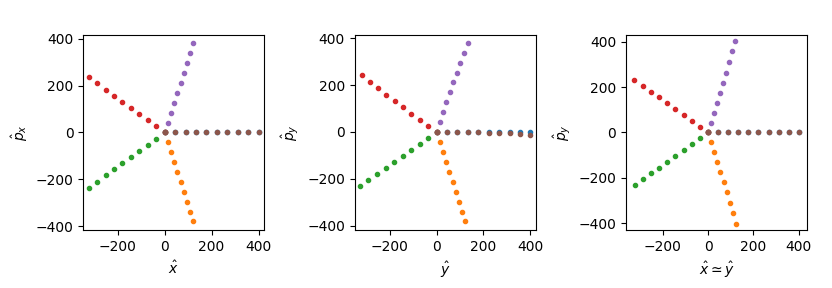

In [31]:
sf = starfish.run(plot=True)

### Back to initial tunes

In [32]:
opt_tunes.reload(0)

In [33]:
tw = line.twiss4d()

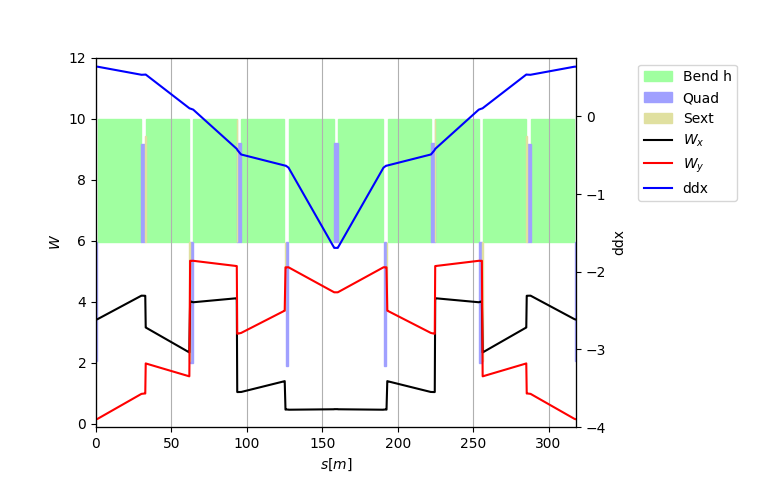

In [34]:
pp = tw.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_hi=12, right_lo=-4)

### Save sextupole strengths

In [35]:
out_ks_vars = ['ksf1', 'ksf2', 'ksd1', 'ksd2',
            'ksffam1', 'ksffam2', 'ksdfam1', 'ksdfam2']
tt_vars = line.vars.get_table()
tt_ks_vars = tt_vars.rows[out_ks_vars]

In [36]:
strengths = tt_ks_vars.to_dict()

In [37]:
strengths

{'ksf1': 'ksffam1',
 'ksf2': 'ksffam2',
 'ksd1': 'ksdfam1',
 'ksd2': 'ksdfam2',
 'ksffam1': np.float64(0.2818176159727364),
 'ksffam2': np.float64(0.2441980981863332),
 'ksdfam1': np.float64(-0.27022135645114226),
 'ksdfam2': np.float64(-0.15607123204890766)}

In [26]:
xt.json.dump(strengths, 'strengths_sext_00_arc_cell.json')